#**Installing tesseract-ocr and language packs for -tam**


In [ ]:
!apt-get install tesseract-ocr
!apt-get install tesseract-ocr-tam

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,788 kB/s)
Selecting previously unselect

In [ ]:
!wget https://github.com/tesseract-ocr/tessdata_best/blob/main/tam.traineddata
!ls -ltr /usr/share/tesseract-ocr/4.00/tessdata/tam.traineddata

--2022-07-06 15:21:36--  https://github.com/tesseract-ocr/tessdata_best/blob/main/tam.traineddata
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘tam.traineddata’

tam.traineddata         [ <=>                ] 129.29K   721KB/s    in 0.2s    

2022-07-06 15:21:36 (721 KB/s) - ‘tam.traineddata’ saved [132390]

-rw-r--r-- 1 root root 3237963 Sep 15  2017 /usr/share/tesseract-ocr/4.00/tessdata/tam.traineddata


In [ ]:
!tesseract --version

tesseract 4.0.0-beta.1
 leptonica-1.75.3
  libgif 5.1.4 : libjpeg 8d (libjpeg-turbo 1.5.2) : libpng 1.6.34 : libtiff 4.0.9 : zlib 1.2.11 : libwebp 0.6.1 : libopenjp2 2.3.0

 Found AVX2
 Found AVX
 Found SSE


In [ ]:
!pip install pybind11
!pip install fastwer
!pip install pytesseract
!pip install Pillow==9.0.0
!pip install Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#**Importing required packages**

In [ ]:
import cv2
try:
    from PIL import Image
except ImportError:
    import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab.patches import cv2_imshow

#**Extracting text from TIFF files**



##**Implementation on a single TIFF file**


In [ ]:
inp = "/content/drive/MyDrive/ocr/Scan 18.tiff"

In [ ]:
img = cv2.imread(inp)
# graying out the image for easy access
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imwrite("/content/gray.tiff", gray)
# blurring the image to recognize text blocks
blur = cv2.GaussianBlur(gray, (7,7), 0)
cv2.imwrite("/content/blur.tiff", blur)
# thresholding the image to highlight the text
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
cv2.imwrite("/content/thresh.tiff", thresh)
kernal = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 3))
cv2.imwrite("/content/kernal.tiff", kernal)
# dilating the image to find blocks to draw contours
dilate = cv2.dilate(thresh,kernal,iterations=2)
cv2.imwrite("/content/dilate.tiff", dilate)

True

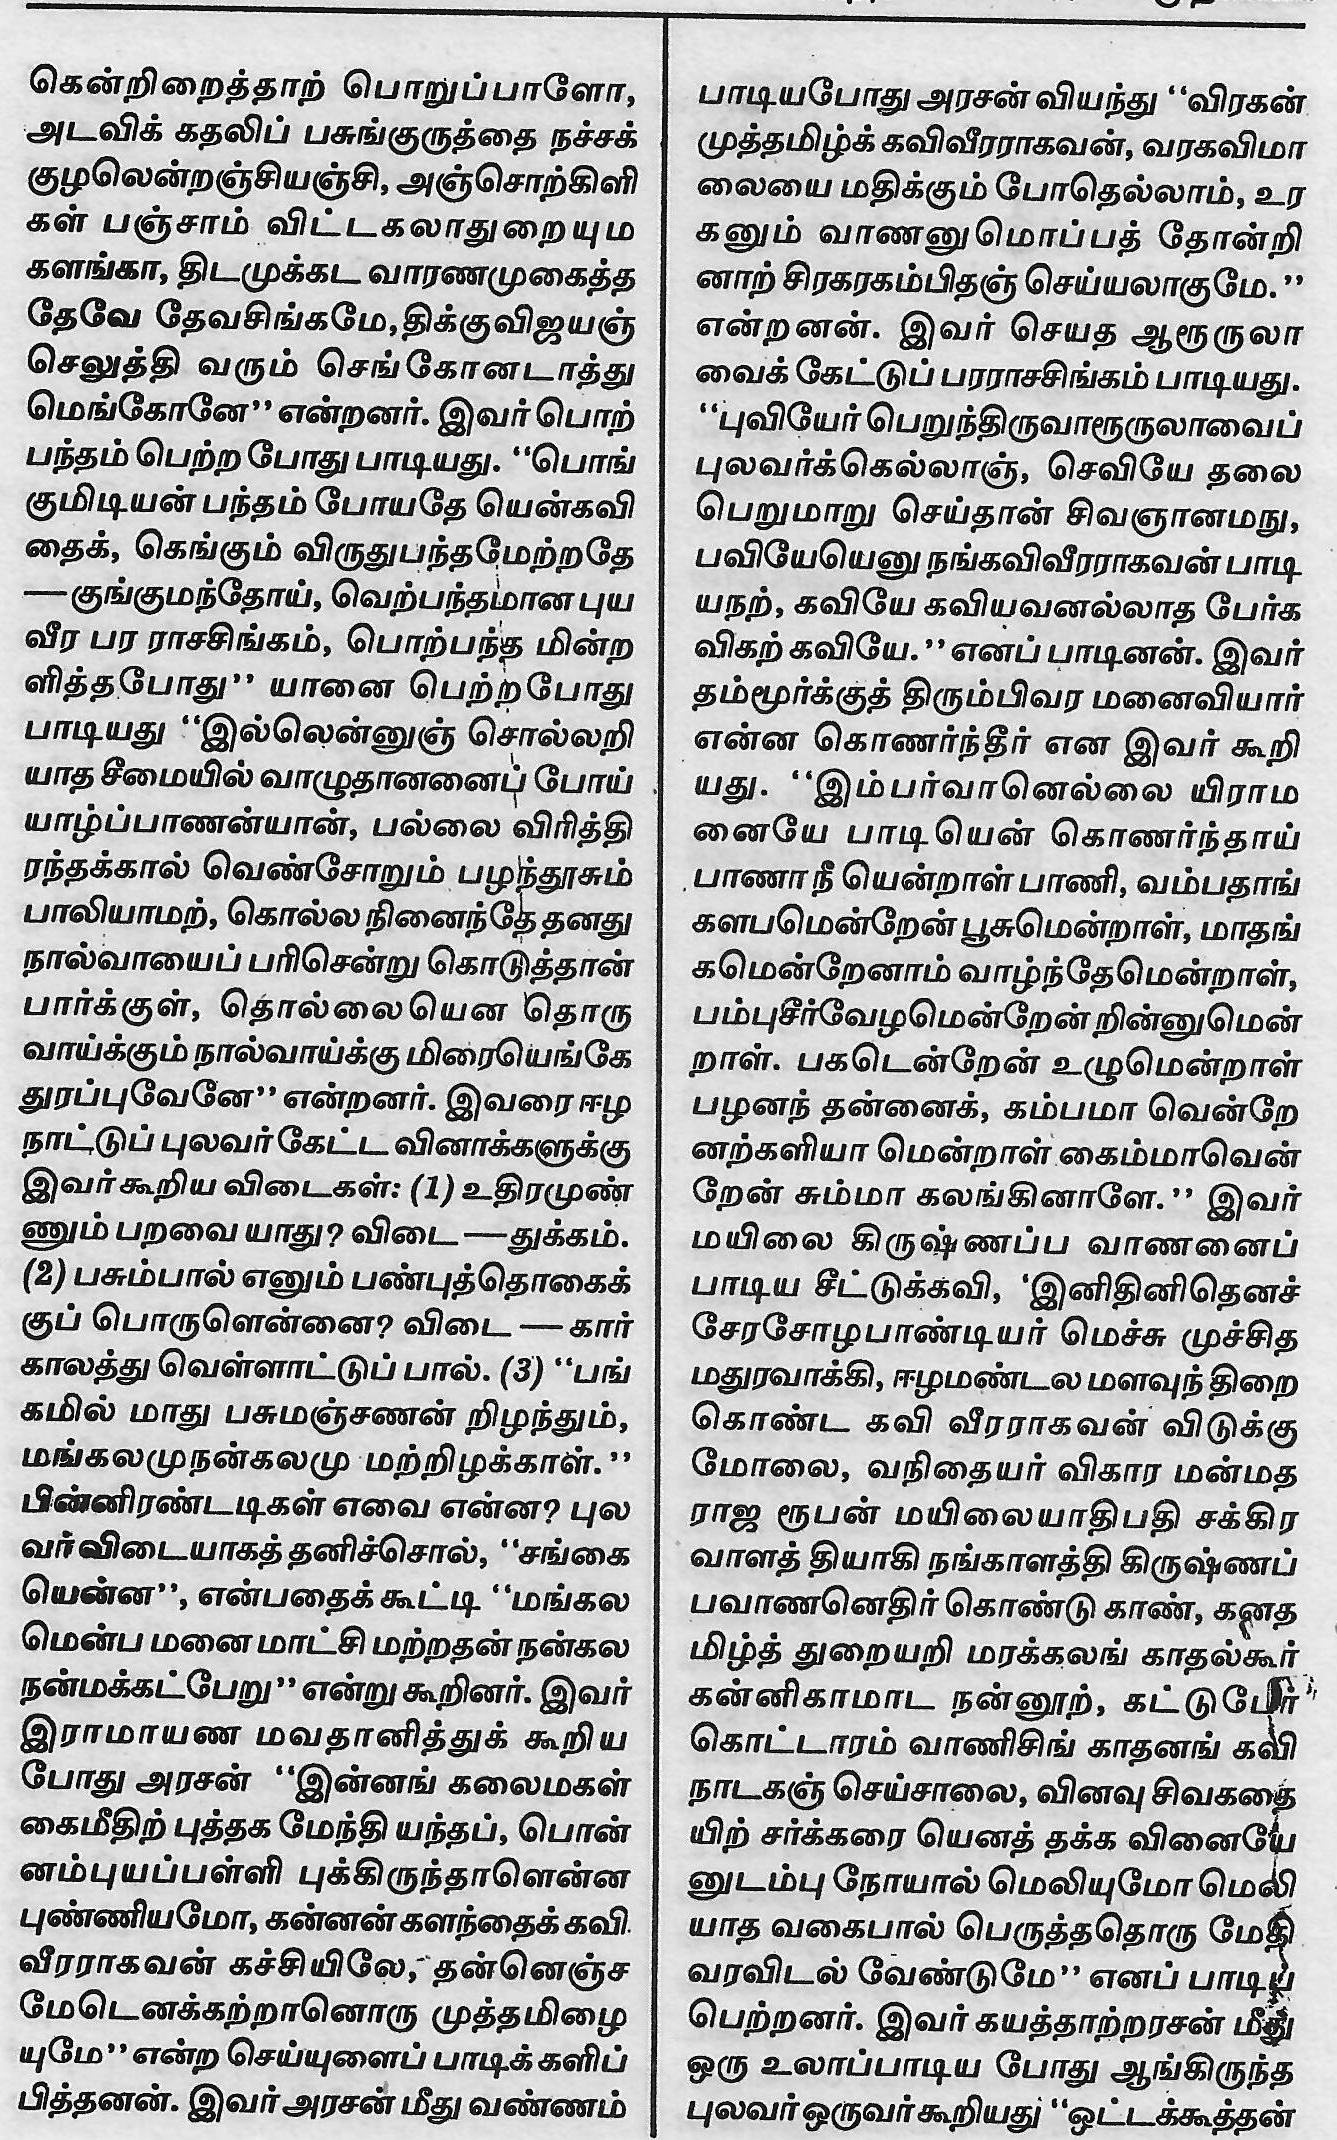

In [ ]:
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts)==2 else cnts[1]
cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])
for c in cnts:
  x,y,w,h = cv2.boundingRect(c)
  if h>200 and w>20:
      bound = img[y:y+h, x:x+w]
      fname = '/content/bound.tiff'
      cv2.imwrite(fname, bound)
  cv2.rectangle(img, (x,y), (x+w, y+h), (36, 255, 12), 2)
Image.open('/content/bound.tiff')

In [ ]:
!tesseract '/content/bound.tiff' '/content/bound' -l tam+eng

Tesseract Open Source OCR Engine v4.0.0-beta.1 with Leptonica
Page 1
Warning. Invalid resolution 0 dpi. Using 70 instead.
Estimating resolution as 347


##**Cleaning the Recognised OCR Text**

In [ ]:
with open('/content/manual.txt', 'r') as file1:
    manual = file1.read().rstrip()

with open('/content/bound.txt', 'r') as file2:
    proposed_out = file2.read().rstrip()

with open('/content/ocr_out.txt', 'r') as file3:
    existing_out = file3.read().rstrip()

manual = manual.replace("\n", "")
manual = manual.replace("\'", "")
manual = manual.replace("\n", "")
manual = manual.replace("\u200c", "")
manual = manual.replace("\ufeff", "")
manual = manual.replace("\'", "")
manual = manual.replace("_", "")
manual = manual.replace(":", "")

proposed_out = proposed_out.replace("\n", "")
proposed_out = proposed_out.replace("\u200c", "")
proposed_out = proposed_out.replace("\'", "")
proposed_out = proposed_out.replace("_", "")
proposed_out = proposed_out.replace(":", "")

existing_out = existing_out.replace("\n", "")
existing_out = existing_out.replace("\u200c", "")
existing_out = existing_out.replace("\'", "")
existing_out = existing_out.replace("_", "")
existing_out = existing_out.replace(":", "")

In [ ]:
manual

' கென்றிறைத்தாற் பொறுப்பாளோ,அடவிக் கதலிப் பசுங்குருத்தை நச்சக்குழலென்றஞ்சியஞ்சி, அஞ்சொற்கிளிகள் பஞ்சாம் விட்டகலாதுறையுமகளங்கா, திடமுக்கட வாரணமுகைத்ததேவே தேவசிங்கமே, திக்குவிஜயஞ்செலுத்தி வரும் செங்கோனடாத்துமெங்கோனே" என்றனர். இவர் பொற்பந்தம் பெற்ற போது பாடியது. "பொங்குமிடியன் பந்தம் போயதே யென்கவிதைக், கெங்கும் விருதுபந்தமேற்றதே--குங்குமந்தோய், வெற்பந்தமான புயவீர பர ராசசிங்கம், பொற்பந்த மின்றளித்தபோது” யானை பெற்றபோதுபாடியது "இல்லென்னுஞ் சொல்லறியாத சீமையில் வாழுதானனைப் போய்யாழ்ப்பாணன்யான், பல்லை விரித்திரந்தக்கால் வெண்சோறும் பழந்தூசும்பாலியாமற், கொல்ல நினைந்தே தனதுநால்வாயைப் பரிசென்று கொடுத்தான்பார்க்குள், தொல்லையென தொருவாய்க்கும் நால்வாய்க்கு மிரையெங்கேதுரப்புவேனே" என்றனர். இவரை ஈழநாட்டுப் புலவர்கேட்ட வினாக்களுக்குஇவர்கூறிய விடைகள் (1) உதிரமுண்ணும் பறவை யாது? விடை-- துக்கம்.(2) பசும்பால் எனும் பண்புத்தொகைக்குப் பொருளென்னை? விடை -- கார்காலத்து வெள்ளாட்டுப் பால். (3) "பங்கமில் மாது பசுமஞ்சணன் றிழந்தும்,மங்கலமுநன்கலமு மற்றிழக்காள். "பின்னிரண்டடிகள் எவை என்ன? புலவர்விடையாகத் தனிச்சொல், "சங்கை

In [ ]:
existing_out

'அந்தகக்கவி வீரராகவமுதலியார்கென்றிறைத்தாற் பொறுப்பாளோ,அடவிக் கதலிப் பசுங்குருத்தை நச்சக்குழலென்றஞ்சியஞ்சி, அஞ்சொற்கிளி.கள் பஞ்சாம் விட்டகலாதுறையுமகளங்கா, திடமுக்கட வாரணமுகைத்த.தேவே தேவங்கமே,திக்குவிஜயஞ்செலுத்தி வரும் செங்கோனடாத்துமெங்கோனே” என்றனர். இவர் பொற்பந்தம் பெற்ற போது பாடியது. பொங்குமிடியன் பந்தம் போயதே யென்கவிதைக், கெங்கும் விருதுபந்தமேற்றதே--குங்குமநீதோய், வெற்பந்தமான புயவீர பர ராசசிங்கம், பொற்பந்த மின்றளித்தபோது** யானை பெற்றபோதுபாடியது இல்லென்னுஞ் சொல்லறியாத சீமையில் வாழுதானனைப் போய் ;.யாழ்ப்பாணன்யான், பல்லை விரித்திரந்தக்கால் வெண்சோறும் பழந்தூசும்பாலியாமற், கொல்ல நினைந்தே தனதுநால்வாயைப் பரிசென்று கொடுத்தான்பார்க்குள், தொல்லையென தொருவாய்க்கும் நால்வாய்க்கு மிரையெங்கேதுரப்புவேனே என்றனர். இவரை ஈழநாட்டுப் புலவர்கேட்ட வினாக்களுக்குஇவர்கூறிய விடைகள் (1) உதிரமுண்ணும் பறவையாது? விடை--துக்கம்.(8) பசும்பால் எனும் பண்புத்தொகைக்குப் பொருளென்னை? விடை -- கார்காலத்து வெள்ளாட்டுப் பால். (3) “பங்கமில் மாது பசுமஞ்சணன் நிழந்தும்,மங்கலமுநன்கலமு மற்றிழக்காள். *பின்னிரண்டடிகள் எவை என்ன? புலவர்விட

In [ ]:
proposed_out

' கென்றிறைத்தாற் பொறுப்பாளோ,அடவிக் கதலிப் பசுங்குருத்தை நச்சக்குழலென்றஞ்சியஞ்சி, அஞ்சொற்கிளிகள் பஞ்சாம் விட்டகலாதுறையுமகளங்கா, திடமுக்கட வாரணமுகைத்ததேவே தேவசிங்கமே, திக்குவிஜயஞ்செலுத்தி வரும் செங்கோனடாத்துமெங்கோனே” என்றனர். இவர்பொற்பநீதம் பெற்ற போது பாடியது. “பொங்குமிடியன் பந்தம் போயதே யென்கவிதைக், கெங்கும் விருதுபந்தமேற்றதே--குங்குமந்தோய், வெற்பந்தமானபுயவீர பர ராசிங்கம், பொற்பந்த மின்றளித்த போது” யானை பெற்றபோதுபாடியது “இல்லென்னுஞ் சொல்லறியாத சீமையில் வாழுதானனைப் போய் ,யாழ்ப்பாணன்யான், பல்லை விரித்திரந்தக்கால் வெண்சோறும் பழந்தூசும்பாலியாமற், கொல்ல நினைந்தே தனதுநால்வாயைப் பரிசென்று கொடுத்தான்பார்க்குள், தொல்லையென தொருவாய்க்கும் நால்வாய்க்கு மிரையெங்கேதுரப்புவேனே” என்றனர். இவரைஈழநாட்டுப் புலவர்கேட்ட வினாக்களுக்குஇவர்கூறிய விடைகள் (2) உதிரமூண்ணும் பறவையாது? விடை--துக்கம்.(2) பசும்பால் எனும் பண்புத்தொகைக்குப் பொருளென்னை? விடை -- கார்காலத்து வெள்ளாட்டுப் பால். (3) “பங்கமில் மாது பசுமஞ்சணன் நிழந்தும்,மங்கலமுநன்கலமு மற்றிழக்காள். *பின்னிரண்டடிகள் எவை என்ன? பூலவர்விடையாகத் தனிச்சொல், “சங்கையென

##**Evaluation Metrics**

In [ ]:
import fastwer
print("Accuracy of the Online OCR:   %.2f" %(100 - fastwer.score_sent(existing_out, manual, char_level=True)))
print("Accuracy of the Proposed OCR: %.2f" %(100 - fastwer.score_sent(proposed_out, manual, char_level=True)))

Accuracy of the Online OCR:   96.00
Accuracy of the Proposed OCR: 98.10


In [ ]:
from Levenshtein import distance
print("Levenshtein Distance of Online OCR:   " + str(distance(manual, existing_out)))
print("Levenshtein Distance of Proposed OCR: " + str(distance(manual, proposed_out)))

Levenshtein Distance of Online OCR:   131
Levenshtein Distance of Proposed OCR: 79


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

f1 = open('/content/manual.txt', 'r')
f2 = open('/content/bound.txt', 'r')
docs=[f1.read(), f2.read()]

# Create TFidfVectorizer
tfidf= TfidfVectorizer()

# Fit and transform the documents
tfidf_vector = tfidf.fit_transform(docs)

# Computing cosine similarity
similar = cosine_similarity(tfidf_vector, tfidf_vector)

print("Accuracy of Proposed OCR based on the manual text: %.1f%%" %(similar[0][1]*100))

Accuracy of Proposed OCR based on the manual text: 98.6%


##**Implementation on a multiple TIFF files**


In [ ]:
import pytesseract
for i in range(1,10):
  custom_config = r'-c preserve_interword_spaces=1 -l eng+tam -psm 3'
  fname = '/content/drive/MyDrive/ocr/Scan ' + str(i) + '.tiff'
  extracted_text = pytesseract.image_to_string(Image.open(fname), config=custom_config)
  f = open('/content/proposed_output.txt', 'w+')
  f.write(extracted_text)
  f.close()
  fin = open('/content/proposed_output.txt', "r")
  data = fin.read()
  fin.close()
  fproposed_out = open('/content/final.txt', "a")
  fproposed_out.write(data)
  fproposed_out.close()

In [ ]:
final = open('/content/proposed_output.txt', "r")
all = final.read()

all = all.replace("\n", "")
all = all.replace("\'", "")
all = all.replace("\n", "")
all = all.replace("\u200c", "")
all = all.replace("\ufeff", "")
all = all.replace("\'", "")
all = all.replace("_", "")
all = all.replace(":", "")

all

'அநிலன்4, அட்டவசுக்களில் ஒருவன்.அநிலன் ர. கருட புத்திரன்.2. அட்டவசுக்களில் ஒருவன்.  இவன்தேவிசிவை. புத்திரன் மனோஜவன்.3. மாலியின் மகன்.அநீகன் -- 1. யதுவம்சத்தவனான அதகன்குமரன்.அநு---. (௪.) யயாதிக்குச்சன்மிஷ்டையிடம் பிறந்த குமரன். இவன் குமரன்சபாநரன்.2. புருவசன் குமரன். இவன் குமார்புருவோத்ரன், அங்கிசு.3. விலோமாகுமரன்.  இவன்குமரன்துந்துபி.அநுகீதை-- பாரதம் அசுவமேத யாகத்திற் கூறப்பட்ட வேதாந்த நூல்.அநுகை -- காசிபர் மனைவி. தக்ஷன்பெண். இவள் குமரர்ூத்தர்.அநுக்கிலாதன்---திதிவம்சத்தவனானஇரண்யகிபின் குமரன். பிரகலாதன்தம்பி. பாரி சூசமி. குமரர் பாஷ்கிலன்,மகிஷன். ~அநுக்கிரகா--- நவசத்திகளில் ஒருத்தி.அந.க்கி ராதன்--குரோதத்தால் நஷ்டமடைந்த அரசன்.அறுசதிகன் -- நூறு காலாட்களுக்குத்தலைவன். சதானீகனுக் குதவி செய்பவன். (சுக்கிர நீதி).அநுசாமந்தன் — அரசனால் நூறு கிராமங்களுக்கு அதிபதியாக நியமிக்கப்பட்டவள். /சுககிர நீதி).அநு£-கன்-- திருதராட்டிரன் குமரன்.அநுதாபகன்--தநுவின் குமரன், .அநுதிதகாலம்--இராக்காலத்தைப் பதினாறு பங்காக்குமிடத்துக் கிரகங்களும்நக்ஷத்திரங்களும் பிறவுங் காணப்படுகின்ற கடைப்பாகம். (பராசரமாதவியம்).அநுபசங்க